### Quantile Regression Tutorial

#### 特点

- 一般回归模型对自变量与因变量均值进行回归，假定了预测的误差的方差是固定的（实际中有时并不是）
- 分位数回归对自变量与因变量的不同条件分位数进行回归
- 可以得到一个置信区间，通过不同的分位了解预测的方差

#### 基本原理

假定因变量真实值为 $ y=(y_1, y_2, ..., y_n) $，目标值为 $ \hat{y} = (\hat{y_1}, \hat{y_2}, ..., \hat{y_n}) $

分位数回归的损失函数是：

$$ L_r(y, \hat{y}) = (1-r)\frac{1}{N}\sum^{i}_{\hat{y_i}\geq y_i}(\hat{y_i}-y_i) + r\frac{1}{N}\sum^{i}_{\hat{y_i}< y_i}(y_i-\hat{y_i}) $$

其中 r 是分位数系数，这个损失函数是平均绝对误差的拓展，当 r=0.5 时退化成 LAD regression（Least absolute deviations）。

Intuition：当 r > 0.5 时，损失函数对预测值偏小的数据惩罚更大（使 fitting 到曲线上移，值更大）；当 r > 0.5 时，损失函数对预测值偏小的数据惩罚更大。即 r 控制了模型对于该分位系数下两类数据的不同惩罚程度。

#### 梯度

使用最简单的线性模型 y = wx + b ，上述损失函数对应 w,b 的梯度为

$$ \frac{dL_{w,b}}{dw} = (1-r)\frac{1}{N}\sum^{i}_{wx_i+b\geq y_i}x_i + r\frac{1}{N}\sum^{i}_{wx_i+b< y_i}(-x_i) $$

$$ \frac{dL_{w,b}}{db} = (1-r)\frac{1}{N}\sum^{i}_{wx_i+b\geq y_i}\times1 + r\frac{1}{N}\sum^{i}_{wx_i+b< y_i}\times(-1) $$


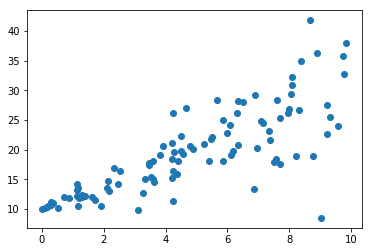

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# generate data with varying variances
X = np.random.uniform(0, 10, (100, 1))
Y = 2 * X + 10 + np.random.normal(0, 0.8 * X)

plt.scatter(X, Y)

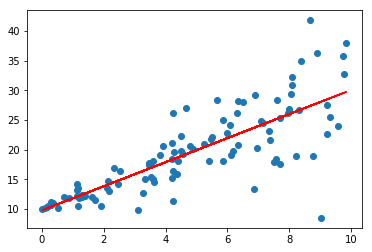

In [2]:
# normal linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, Y)
plt.scatter(X, Y)
plt.plot(X, lr.predict(X), color='red')

In [25]:
# 一个无敌简易版的分位数回归
class QuantileRegression:
    def __init__(self, r=0.5):
        self.r = r
        self.batch = 8
        self.w, self.b = 0.0, 0.0
        self.lr = 0.1
        
    def fit(self, X, y):
        for n in range(5000):
            random_idx = np.random.randint(0, len(X), self.batch)
            train_X, train_y = X[random_idx], Y[random_idx]
            pred_y = self.w * train_X + self.b
            grad_w = np.mean((pred_y > train_y) * (1 - self.r) * train_X) + np.mean((pred_y < train_y) * self.r * - train_X)
            grad_b = np.mean((pred_y > train_y) * (1 - self.r)) + np.mean((pred_y < train_y) * self.r * -1)
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b 
        print('training done! w: %.4f b: %.4f' % (self.w, self.b))
        
    def predict(self, X):
        return self.w * X + self.b
    

training done! w: 0.9305 b: 9.5375
training done! w: 2.1781 b: 10.0625
training done! w: 2.8371 b: 10.1125


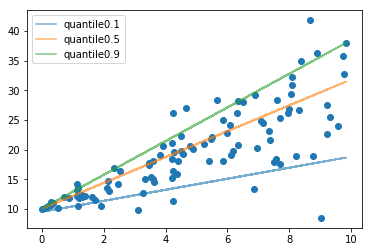

In [27]:
plt.scatter(X, Y)
for r in [0.1, 0.5, 0.9]:
    qr = QuantileRegression(r)
    qr.fit(X, Y)
    plt.plot(X, qr.predict(X), label='quantile'+str(r), alpha=0.6)
plt.legend()

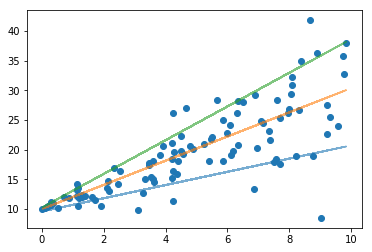

In [28]:
# 和 StatsModel 的包对比一下
import pandas as pd
import statsmodels.formula.api as smf

data = pd.DataFrame(np.hstack([X, Y]), columns=['x', 'y'])
mod = smf.quantreg('y ~ x', data)

plt.scatter(X, Y)
for r in [0.1, 0.5, 0.9]:
    res = mod.fit(q=r)
    y_ = res.params['x'] * X + res.params['Intercept']
    plt.plot(X, y_, label='quantile'+str(r), alpha=0.6)


### Ref
- [这份 tutorial 的前几页](https://support.sas.com/resources/papers/proceedings17/SAS0525-2017.pdf)
- [StatsModels Example](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)